In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
import csv
df = pd.read_csv("questions.csv", quoting=csv.QUOTE_NONE, on_bad_lines='skip', engine='python')
print(df.head())

  "id" "qid1" "qid2"                                        "question1"  \
0    0      1      2  "What is the step by step guide to invest in s...   
1    1      3      4  "What is the story of Kohinoor (Koh-i-Noor) Di...   
2    2      5      6  "How can I increase the speed of my internet c...   
3    6     13     14                              "Should I buy tiago?"   
4    7     15     16                   "How can I be a good geologist?"   

                                         "question2" "is_duplicate"  
0  "What is the step by step guide to invest in s...            "0"  
1  "What would happen if the Indian government st...            "0"  
2  "How can Internet speed be increased by hackin...            "0"  
3  "What keeps childern active and far from phone...            "0"  
4        "What should I do to be a great geologist?"            "1"  


checking the dataframe

In [ ]:
df = df[:2000]

In [ ]:
print(df.columns)

Index(['"id"', '"qid1"', '"qid2"', '"question1"', '"question2"',
       '"is_duplicate"'],
      dtype='object')


In [ ]:
print(df.shape)

(2000, 6)


In [ ]:
print(df.describe())

        "id" "qid1" "qid2"            "question1"  \
count   2000   2000   2000                   1999   
unique  2000   2000   2000                   1991   
top        0      1      2  "Why do Slavs squat?"   
freq       1      1      1                      2   

                                       "question2" "is_duplicate"  
count                                         1998           1998  
unique                                        1987              2  
top     "How can I hack another WhatsApp account?"            "0"  
freq                                             2           1174  


In [ ]:
print(df.isnull().sum())

"id"              0
"qid1"            0
"qid2"            0
"question1"       1
"question2"       2
"is_duplicate"    2
dtype: int64


In [ ]:
df.columns = df.columns.str.replace('"', '', regex=False)

In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string

nltk.download('stopwords')
nltk.download('wordnet')
lemmer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def text_cleaner(text):
    if text is None:  # Check for None values
        return ""
    # Remove punctuations
    text = "".join([char for char in text if char not in string.punctuation])
    # Tokenize
    words = text.split()
    # Remove stopwords
    words = [word for word in words if word.lower() not in stopwords.words("english")]
    # Lemmatize
    words = [WordNetLemmatizer().lemmatize(word) for word in words]
    return " ".join(words)

# Apply to both question1 and question2
df['question1_cleaned'] = df['question1'].apply(text_cleaner)
df['question2_cleaned'] = df['question2'].apply(text_cleaner)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer()
questions_tfidf = tfidf.fit_transform(df['question1_cleaned'] + df['question2_cleaned'])


In [ ]:
print(df['is_duplicate'].value_counts())

is_duplicate
"0"    1174
"1"     824
Name: count, dtype: int64


In [ ]:
from sklearn.utils import resample

# Separate majority and minority classes
df_majority = df[df['is_duplicate'] == 0]
df_minority = df[df['is_duplicate'] == 1]

# Check sizes
print(f"Majority class size: {len(df_majority)}")
print(f"Minority class size: {len(df_minority)}")

# Oversample the minority class only if it exists
if len(df_minority) > 0:
    df_minority_oversampled = resample(df_minority,
                                        replace=True,   # Sample with replacement
                                        n_samples=len(df_majority),  # Match majority class size
                                        random_state=42)  # Reproducibility

    # Combine majority class with oversampled minority class
    df_oversampled = pd.concat([df_majority, df_minority_oversampled])
else:
    print("No minority class entries to oversample.")
    df_oversampled = df_majority  # or handle as needed

# Shuffle the dataset
df_oversampled = df_oversampled.sample(frac=1, random_state=42)


Majority class size: 0
Minority class size: 0
No minority class entries to oversample.


In [ ]:
pip install imblearn

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Load your DataFrame (ensure you load your dataset correctly)
# df = pd.read_csv("your_file.csv")

# Check for missing values in target variable and handle them
df = df.dropna(subset=['is_duplicate'])  # Drop rows where target is NaN

# Create features using TF-IDF after handling missing values
vectorizer = TfidfVectorizer()
questions_tfidf = vectorizer.fit_transform(df['question1_cleaned'] + " " + df['question2_cleaned'])

# Separate features and target variable
X = questions_tfidf
y = df['is_duplicate'].astype(int)  # Ensure target labels are integers

# Splitting data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
clf = LogisticRegression()
clf.fit(X_train, y_train)

# Evaluate accuracy
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')


Accuracy: 68.50%


In [ ]:
from sklearn.metrics import classification_report

y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.67      0.91      0.77       234
           1       0.74      0.37      0.50       166

    accuracy                           0.69       400
   macro avg       0.70      0.64      0.63       400
weighted avg       0.70      0.69      0.66       400



# **BERT**

In [ ]:
pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 472.7/472.7 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 16.8 MB/s eta 0:00:00


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer
import torch
from datasets import Dataset

# Load the CSV file
df = pd.read_csv("questions.csv", quoting=csv.QUOTE_NONE, on_bad_lines='skip', engine='python')
df = df[:2000]
df.columns = df.columns.str.replace('"', '', regex=False)

# Ensure the questions are strings and handle missing values
df['question1'] = df['question1'].fillna('').astype(str)
df['question2'] = df['question2'].fillna('').astype(str)

# Combine the two questions into one input (BERT uses the [SEP] token for paired inputs)
df['text'] = df['question1'] + " [SEP] " + df['question2']

# Split the data
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['text'], df['is_duplicate'], test_size=0.2, random_state=42
)

# Convert to Hugging Face Dataset format
train_df = pd.DataFrame({'text': train_texts, 'label': train_labels})
val_df = pd.DataFrame({'text': val_texts, 'label': val_labels})

# Ensure text is of string type before converting to Dataset
train_df['text'] = train_df['text'].astype(str)
val_df['text'] = val_df['text'].astype(str)

train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from transformers import BertTokenizer

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE
import pandas as pd

# Example dataframe with two columns of questions and target
# df = pd.DataFrame({'question1': [...], 'question2': [...], 'is_duplicate': [...]})

# Combine both question columns into a single text column for TF-IDF vectorization
df['text'] = df['question1'].fillna('') + " " + df['question2'].fillna('')

# Remove any rows where target is missing
df = df.dropna(subset=['is_duplicate'])

# Initialize the TF-IDF vectorizer
tfidf = TfidfVectorizer(max_features=1000)  # Adjust max_features based on dataset size

# Fit and transform the text into TF-IDF vectors
X_tfidf = tfidf.fit_transform(df['text'])
# Remove extra quotes from the 'is_duplicate' column and convert to integers
df['is_duplicate'] = df['is_duplicate'].str.replace('"', '').astype(int)

# Now proceed with the rest of the code
y = df['is_duplicate']  # Target labels as integers

# Apply SMOTE as before
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_tfidf, y)

print(f"Resampled dataset shape: {X_resampled.shape}, {y_resampled.shape}")


Resampled dataset shape: (2348, 1000), (2348,)


In [ ]:
def tokenize_function(examples):
    return tokenizer(
        examples['text'],
        padding='max_length',  # or padding=True if you want dynamic padding
        truncation=True,
        max_length=128
    )

train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/1600 [00:00<?, ? examples/s]

Map:   0%|          | 0/400 [00:00<?, ? examples/s]

In [ ]:
train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
val_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

In [ ]:
from transformers import DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [ ]:
from transformers import BertForSequenceClassification

# Load pre-trained BERT model for sequence classification
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)  # Binary classification


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 3.9 MB/s eta 0:00:00


In [ ]:
import evaluate

In [ ]:
from transformers import TrainingArguments

In [ ]:
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=5,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=8,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=5,
    evaluation_strategy="epoch",  # Change to epoch
    save_strategy="epoch",
    load_best_model_at_end=True,
    save_total_limit=2,
)

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    acc = accuracy_score(labels, preds)
    return {'accuracy': acc}


In [ ]:
from transformers import Trainer

In [ ]:
# Fill any None values with a default (e.g., 0) and remove quotes, then convert to integers
train_df['label'] = train_df['label'].fillna("0").str.replace('"', '').astype(int)
val_df['label'] = val_df['label'].fillna("0").str.replace('"', '').astype(int)

# Convert to Hugging Face Dataset
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)

In [ ]:
from transformers import BertTokenizer, DataCollatorWithPadding, Trainer, TrainingArguments

# Initialize the tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize the dataset
def tokenize_data(examples):
    return tokenizer(examples['text'], padding='max_length', truncation=True, max_length=128)

train_dataset = train_dataset.map(tokenize_data, batched=True)
val_dataset = val_dataset.map(tokenize_data, batched=True)

# Set the format to PyTorch tensors and specify columns
train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
val_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

# Use DataCollatorWithPadding for dynamic padding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Set up Trainer
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    logging_dir="./logs",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=data_collator,  # Ensure inputs are properly padded
    tokenizer=tokenizer,
)

# Train the model
trainer.train()


Map:   0%|          | 0/1600 [00:00<?, ? examples/s]

Map:   0%|          | 0/400 [00:00<?, ? examples/s]

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss
1,No log,0.533376
2,No log,0.533038
3,0.469800,0.750910


TrainOutput(global_step=600, training_loss=0.43185986200968424, metrics={'train_runtime': 173.1133, 'train_samples_per_second': 27.728, 'train_steps_per_second': 3.466, 'total_flos': 315733266432000.0, 'train_loss': 0.43185986200968424, 'epoch': 3.0})

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score
from transformers import TrainerCallback

# Define a custom metric function for accuracy
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return {'accuracy': accuracy_score(labels, predictions)}

# Update the Trainer to include the compute_metrics function
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics  # Add metric computation
)

# Evaluate the model
eval_results = trainer.evaluate()
print(f"Validation Accuracy: {eval_results['eval_accuracy'] * 100:.2f}%")


Validation Accuracy: 75.50%


In [ ]:
print(df['is_duplicate'].value_counts())

is_duplicate
0    1174
1     824
Name: count, dtype: int64


In [ ]:
# Check if MPS is available (for Apple Silicon)
device = torch.device("mps") if torch.has_mps else torch.device("cpu")

# Move the model to the device
model.to(device)

def get_prediction(question1, question2):
    # Combine the questions into one input using the [SEP] token
    input_text = question1 + " [SEP] " + question2
    inputs = tokenizer(input_text, return_tensors="pt", truncation=True, padding=True)

    # Move inputs to the device
    inputs = {key: value.to(device) for key, value in inputs.items()}

    # Ensure the model is in evaluation mode
    model.eval()

    # Get the output logits
    with torch.no_grad():
        outputs = model(**inputs)

    # Convert logits to probabilities
    probabilities = torch.softmax(outputs.logits, dim=1)

    # Get the predicted label (0 or 1)
    predicted_label = torch.argmax(probabilities).item()

    return predicted_label, probabilities

# Example question pairs
question1 = "How do I increase my internet speed?"
question2 = "What are the ways to boost internet speed?"

# Get prediction
label, probs = get_prediction(question1, question2)
print(f"Predicted Label: {label}, Probabilities: {probs}")


Predicted Label: 1, Probabilities: tensor([[0.0589, 0.9411]])


In [ ]:
test_pairs = [
    ("What are the benefits of drinking water?", "How does drinking water benefit health?"),
    ("How to bake a cake?", "What is the process of baking a cake?"),
    ("What time does the sun rise?", "At what time does the sun rise today?"),
    ("What is the best time to visit Japan?", "How can I learn programming quickly?"),
    ("How do airplanes fly?", "What is the capital of France?")
]

for q1, q2 in test_pairs:
    label, probs = get_prediction(q1, q2)
    print(f"Q1: {q1}\nQ2: {q2}\nPredicted Label: {label}, Probabilities: {probs}\n")



Q1: What are the benefits of drinking water?
Q2: How does drinking water benefit health?
Predicted Label: 1, Probabilities: tensor([[0.0525, 0.9475]])

Q1: How to bake a cake?
Q2: What is the process of baking a cake?
Predicted Label: 0, Probabilities: tensor([[0.9885, 0.0115]])

Q1: What time does the sun rise?
Q2: At what time does the sun rise today?
Predicted Label: 1, Probabilities: tensor([[0.0800, 0.9200]])

Q1: What is the best time to visit Japan?
Q2: How can I learn programming quickly?
Predicted Label: 0, Probabilities: tensor([[0.9935, 0.0065]])

Q1: How do airplanes fly?
Q2: What is the capital of France?
Predicted Label: 0, Probabilities: tensor([[0.9938, 0.0062]])



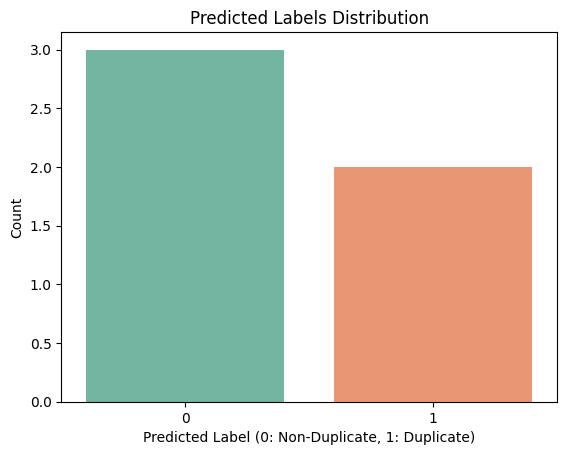

In [ ]:
import seaborn as sns

def plot_predicted_labels(test_pairs):
    # Collect all predicted labels
    labels = []
    for q1, q2 in test_pairs:
        label, _ = get_prediction(q1, q2)
        labels.append(label)

    # Plot bar plot of predicted labels
    sns.countplot(x=labels, palette="Set2")
    plt.title("Predicted Labels Distribution")
    plt.xlabel("Predicted Label (0: Non-Duplicate, 1: Duplicate)")
    plt.ylabel("Count")
    plt.show()

# Plot predicted labels
plot_predicted_labels(test_pairs)


In [ ]:
model.save_pretrained('/content/my_model')
tokenizer.save_pretrained('/content/my_model')

('/content/my_model/tokenizer_config.json',
 '/content/my_model/special_tokens_map.json',
 '/content/my_model/vocab.txt',
 '/content/my_model/added_tokens.json')

In [ ]:
!zip -r my_model.zip /content/my_model

  adding: content/my_model/ (stored 0%)
  adding: content/my_model/special_tokens_map.json (deflated 42%)
  adding: content/my_model/tokenizer_config.json (deflated 75%)
  adding: content/my_model/config.json (deflated 49%)
  adding: content/my_model/vocab.txt (deflated 53%)
  adding: content/my_model/model.safetensors (deflated 7%)


In [ ]:
from google.colab import files
files.download('my_model.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>